# Natural Language Processing with Disaster Tweets

## Business Understanding

In recent years, Twitter has emerged as a critical communication channel during emergencies. Most tweets shared can be about disasters but they can be amiguous. e.g(disaster- related keywords might not always refer to actual disasters, as it can be used in a different context).
> **Objective** :

* The primary goal of this project is to develop a machine learning model using Natural Language Processing (NLP) techniques to accurately classify tweets as either describing a real disaster (1) or not (0).

> **Success Criteria**:

* This project aims to enhance the capability of automated systems in distinguishing between actual disaster-related tweets and those that merely contain disaster-related keywords in a different context. Achieving this goal will enable more accurate and timely identification of real-time emergencies,

## Data Understanding

This Dataset contains the Disaster Tweets which is useful for analysis and predictive modeling.
> Files:
* train.csv - the training set
* test.csv - the test set

The train CSV file has 5 columns and 7613 rows.

The test CSV file has 4 columns and 3263 rows. 

> The following columns are :
* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from
* keyword - a particular keyword from the tweet
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

## Business Problem

**Initial Questions**

* How can we accurately identify tweets that describe real disasters in real-time?

## Data Preparation

#### Importing the libraries and Loading the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Library for handling data in DataFrame format
import pandas as pd
import numpy as np

'/content/drive/MyDrive/Colab Notebooks/Disater_Tweets/train.csv'

#Loading the training data
train_data= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Disater_Tweets/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Disater_Tweets/test.csv')

#Natural language processing libraries
import nltk # for nlp task (library for working with humans language data)
from nltk.corpus import stopwords # To access stopwords for text preprocessing
from nltk.tokenize import word_tokenize  #To split text into individual words (tokens).
from nltk.stem import PorterStemmer # To reduce words to their base or root form (e.g., "running" to "run").
from nltk.stem import WordNetLemmatizer #To reduce words to their meaningful base form (lemma), considering the context

# download required ntlk resourse
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# first few rows of the training data
print(train_data.head())

# Rows and Coumns
print(f"\nThe train dataset has {train_data.shape} rows and columns\n")

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

The train dataset has (7613, 5) rows and columns



In [4]:
# Two columns selected
train_data= train_data[['text', 'target']]

# first few rows of text and target column
train_data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


#### Summary of data

In [5]:
# Overall Structure
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


#### Null Values & Data Cleaning

In [6]:
# Checking missing value
train_data.isnull().sum()

,0
text,0
target,0


In [7]:
# Removing the duplicate entries
train_data.drop_duplicates(keep='first', inplace=True)
# keeping the first occurence before removing duplicates

# Confirming if there are still duplicates
train_data.duplicated().sum()


<ipython-input-7-aeb1fe19e481>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop_duplicates(keep='first', inplace=True)


0

In [8]:
# Updated rows and columns after removing duplicats
print(f"The train dataset has {train_data.shape} rows and columns\n")

The train dataset has (7521, 2) rows and columns



### Exploroatory Data analysis (EDA)

#### Descriptive Data Analysis

In [9]:
# summary statictis
train_data.describe()

,target
count,7521.000000
mean,0.426273
std,0.494567
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [10]:
# Unique values in target column
print(train_data['target'].unique())

[1 0]


#### Disaster vs non Disaster tweet before data modeling

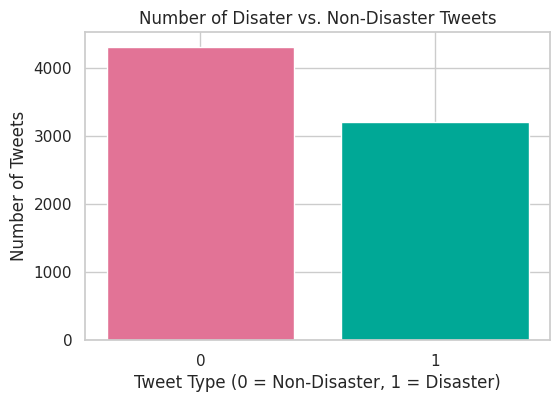

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style = 'whitegrid')

# counting disaster and non disaster tweet
disaster_counts = train_data['target'].value_counts()

#graph plotting
plt.figure(figsize=(6,4))
plt.bar(disaster_counts.index, disaster_counts.values, color=['#e27396', '#00a896'])
plt.xticks([0,1], ['0', '1'])
plt.xlabel('Tweet Type (0 = Non-Disaster, 1 = Disaster)')
plt.ylabel('Number of Tweets')
plt.title('Number of Disater vs. Non-Disaster Tweets')
plt.show()



The above shows that the data is imblanced, one of the reason why f1 score is used

#### Tweet Length Analysis

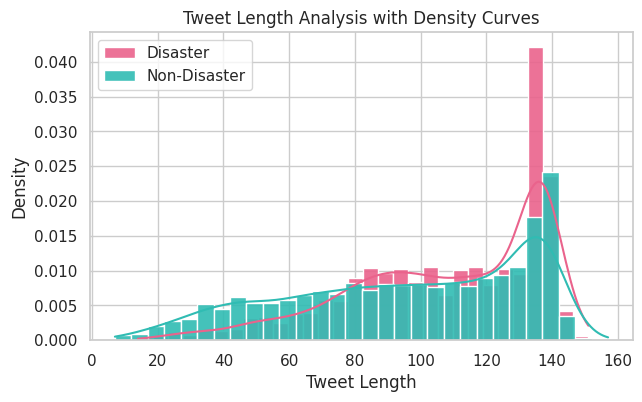

In [12]:
# Copy the dataframe to avoid changing the original one
train_data_copy = train_data.copy()

#Calculate the length of the each tweets
train_data_copy['Tweet_length'] = train_data_copy['text'].apply(len)

# plot styles
sns.set(style= 'whitegrid')

plt.figure(figsize=(7,4))

#Ploting histogram with density curves for Disaster tweet
sns.histplot(train_data_copy[train_data_copy['target']==1]['Tweet_length'], kde =True, color='#ea638c', label ="Disaster", bins= 30, stat='density', alpha=0.9,  multiple='stack')

#Ploting histogram with density curves for Non-Disaster tweet
sns.histplot(train_data_copy[train_data_copy['target']==0]['Tweet_length'], kde =True, color='#30bcb3', label ="Non-Disaster", bins= 30, stat='density', alpha=0.9,  multiple='stack')

#Adding the labels and title
plt.xlabel('Tweet Length')
plt.ylabel('Density')
plt.title('Tweet Length Analysis with Density Curves')
plt.legend()

plt.show()

***Disaster Tweets***:

The density curve for disaster tweets shows a clear peak around the 120-140 character mark. This suggests that disaster-related tweets tend to be longer, possibly due to the need for more information or urgency in communication.


***Non-Disaster Tweets:***

The density curve for non-disaster tweets is more spread out, with a peak around the 60-80 character mark. This indicates a wider range of tweet lengths for non-disaster topics, with many shorter tweets.

### Text Preprocessing

In [13]:
import re  # For regular expression operations (i.e., removing unwanted characters)
from nltk.corpus import stopwords  # For removing stop words
from nltk.tokenize import word_tokenize  # For tokenizing text into words
from nltk.stem import PorterStemmer  # For stemming words
from nltk.stem import WordNetLemmatizer  # For lemmatizing words

# Initializing the stop words, stemmer, and lemmatizer
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Function to clean tweets
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters (punctuation)
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+[a-z]\s+', ' ', text)  # Remove single characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Stem or lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply the preprocessing function to tweets
train_data['cleaned_text'] = train_data_copy['text'].apply(preprocess_text)


In [14]:
# Checking for NaN values in the cleaned_text column
print(train_data['cleaned_text'].isnull().sum())

0


In [15]:
# Drop rows with NaN values in the cleaned_text column
train_data = train_data.dropna(subset=['cleaned_text'])


In [16]:
# Display the first few rows of the cleaned
print(train_data[['text', 'cleaned_text']].head())

                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                        cleaned_text  
0         deed reason earthquake may allah forgive u  
1              forest fire near la ronge sask canada  
2  resident asked shelter place notified officer ...  
3  people receive wildfire evacuation order calif...  
4  got sent photo ruby alaska smoke wildfire pour...  


### Feature Extractions

#### Bag of words(BoW)
<p style="font-size: 15px;">The Bag of Words (BoW) model represents text data by converting it into a matrix of token counts. Each unique word in the document collection becomes a feature, and the value of each feature is the count of that word appears in the document.</p>

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

# Initializing vectorizer which convert text data into matrix of token counts.
vectorizer = CountVectorizer()

# Fit and transform the cleaned training text data
X_bow = vectorizer.fit_transform(train_data['cleaned_text'])
# Fit: Learns the vocabulary from the cleaned_text data.
# Transform: Converts the text data into a matrix of token counts.

# Displaying the vocabulary
print(vectorizer.get_feature_names_out())

# matrix to an array
print(X_bow.toarray())

#Display the shape of the Bow matrix
print(f"\n X_bow is spare matrix where each row : represent tweet & column : unique word from the entire corpus. {X_bow.shape}")


['aa' 'aaaa' 'aaaaaaallll' ... 'ûónegligence' 'ûótech' 'ûówe']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

 X_bow is spare matrix where each row : represent tweet & column : unique word from the entire corpus. (7521, 14876)


#### TF-IDE (Term frequency-Inverse Document Frequency)
<p style="font-size: 15px;">TF-IDF helps in understanding the importance of words in documents relative to a collection of documents.</p>

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initializing the TfidVectorizer to transform text data into TF-IDF matrix.
tfidf= TfidfVectorizer(max_features=5000)
#Term Frequency (TF): Measures how frequently term appears in document.
# Inverse Document Frequency (IDF): Measures how important a term is

# Fit and transform the cleaned training data text data
X_tfidf = tfidf.fit_transform(train_data['cleaned_text'])

# returns the list of feature names (i.e., unique words).
print(tfidf.get_feature_names_out())

# Print the TF-IDF matrix
print("\nTF-IDF Matrix:")
print(X_tfidf.toarray())
print("\nThe matrix represents each row : document and each column : as word ")

['aa' 'ab' 'aba' ... 'ûïyou' 'ûò' 'ûó']

TF-IDF Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

The matrix represents each row : document and each column : as word 


### Model Building and Training

#### Splitting Data

In [19]:
from sklearn.model_selection import train_test_split

# Using the TFIDF features for model building
X = X_tfidf # features (TF-IDF vectors of tweets).

#Defining the target variable

y = train_data['target']

#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)



#### Initializing and Training Model

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Initializing the model(dictonary, keys: model name, values: instances of classifier)
models = {
    'Logistic Regression' : LogisticRegression(),
    'Random Forest' : RandomForestClassifier(),
    'Decision Tree' : DecisionTreeClassifier()
}


In [21]:
# Training each Model and storing the predictions
predictions = {}
for i, model in models.items():
    model.fit(X_train, y_train)


In [22]:
# Making Predictions for each model
predictons = {}
for i, model in models.items():
    predictions[i] = model.predict(X_test)



#### Model Evaluation

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Accuracy scores and classification report
results = {} #empty dictionary
for i, y_pred in predictions.items():
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    results[i] = {
            'f1_score' : f1,
            'accuracy_score': accuracy

        }

# Display result
for i, result in results.items():
    print(f'Model: {i}')
    print(f"f1_score: {result['f1_score']: 4f}")
    print(f"Accuracy Score: {result['accuracy_score']: 4f}")
    print(" ")

Model: Logistic Regression
f1_score:  0.737931
Accuracy Score:  0.798007
 
Model: Random Forest
f1_score:  0.699288
Accuracy Score:  0.775415
 
Model: Decision Tree
f1_score:  0.670373
Accuracy Score:  0.724252
 


#### Training with Best Model

In [24]:
# Logistic Regression Model
model = LogisticRegression()

model.fit(X_train,y_train)

# Predictions and Evaluation
predict = model.predict(X_test)

# f1 score
f1= f1_score(y_test, predict)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print(f"Model is : {model}")
print(f"\nThe f1 score of the model is : {f1:.4f}")
print(f"\nAccuracy Score: {accuracy:.4f}")

Model is : LogisticRegression()

The f1 score of the model is : 0.7379

Accuracy Score: 0.7243


#### Confusion Matrix

In [30]:
print(f"Confusion Matrix : {cm}")
# Classification Report
print("\n Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix : [[668 195]
 [220 422]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.77      0.76       863
           1       0.68      0.66      0.67       642

    accuracy                           0.72      1505
   macro avg       0.72      0.72      0.72      1505
weighted avg       0.72      0.72      0.72      1505



(2, 2)


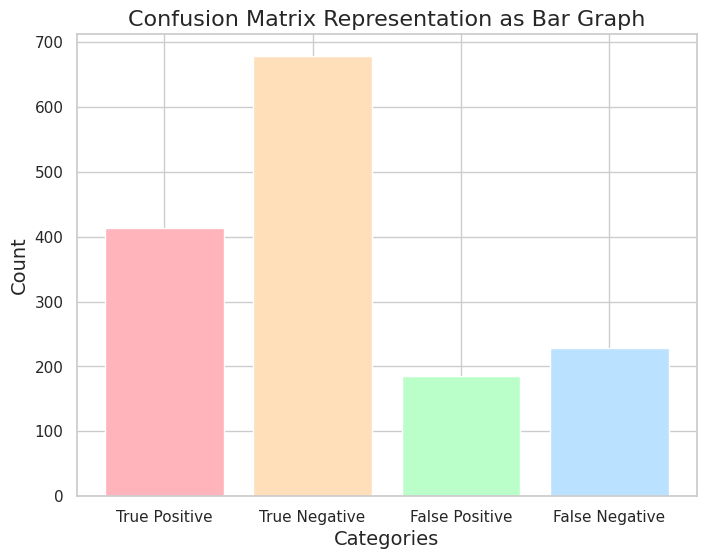

In [26]:
# Data from confusion matrix
confusion_matrix = np.array([[678, 185],
                             [229, 413]])
print(confusion_matrix.shape)

# Define the labels for the axes
labels = ['Non-Disaster', 'Disaster']
categories = ['True Positive', 'True Negative', 'False Positive', 'False Negative']

# Data for bar graph
true_positive = confusion_matrix[1, 1]  # Disaster predicted correctly
true_negative = confusion_matrix[0, 0]  # Non-disaster predicted correctly
false_positive = confusion_matrix[0, 1]  # Non-disaster predicted as disaster
false_negative = confusion_matrix[1, 0]  # Disaster predicted as non-disaster

# Values for the bar graph
values = [true_positive, true_negative, false_positive, false_negative]

# Create bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, values, color=['#FFB3BA', '#FFDFBA', '#BAFFC9', '#BAE1FF'])

# Add title and labels
plt.title('Confusion Matrix Representation as Bar Graph', fontsize=16)
plt.xlabel('Categories', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

#### Submission

In [27]:
# Cleaning the text data in the test set.
test_data['text'] = test_data['text'].apply(preprocess_text)

# Transforms the cleaned text data into TF-IDF feature vectors.
test_tfidf = tfidf.transform(test_data['text'])

# Using trained model to make predictions on the test data
test_pred = model.predict(test_tfidf)

# SUbmission file
submission = pd.DataFrame({'id': test_data['id'], 'target': test_pred})
submission.to_csv('submission.csv', index = False)

#### Submission file overview

In [28]:
sub = pd.read_csv('submission.csv', index_col=False)
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


#### Disaster vs non Disaster tweet After data modeling

Index([0, 1], dtype='int64', name='target')
target
0    2157
1    1106
Name: count, dtype: int64


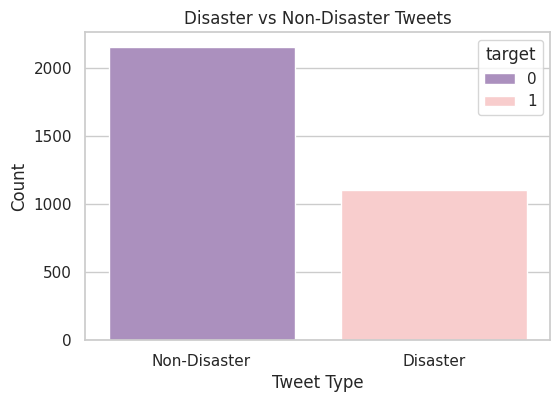

In [29]:
tweet_counts = sub['target'].value_counts()
print(tweet_counts.index) # index refers to label or categories(0,1)
print(tweet_counts) # counts of each unique value

# Create a bar graph

plt.figure(figsize=(6, 4))
sns.barplot(x=tweet_counts.index, y=tweet_counts.values, hue=tweet_counts.index, palette=['#AD88C6', '#FFC6C6'], legend=True)
plt.xlabel('Tweet Type')
plt.ylabel('Count')
plt.title('Disaster vs Non-Disaster Tweets')
plt.xticks(ticks=[0, 1], labels=['Non-Disaster', 'Disaster'])
plt.show()

## Conclusion


**1.) Objective Achieved:** Successfully developed a machine learning model to classify tweets as either describing a real disaster (1) or not (0).

**2.) Data Preprocessing:** Comprehensive text preprocessing techniques were employed, including:

- Removing non-word characters, stop words, and single-character words.
- Tokenization and lemmatization to standardize the text data for modeling.

**3.) Feature Extraction:** We used two ways to understand the words in tweets:

- Bag of Words: We counted how many times each word appeared in a tweet.
 - TF-IDF: We gave more importance to words that were common in some tweets but rare in others.

**4.) Model Selection and Evaluation:** We tested different algorithms to find the best one for our task:

- Logistic Regression turned out to be the best model, achieving an accuracy of about 72.49% and an F1 score of 0.7397.

**5.) Confusion Matrix:**

- ***True Positives (TP):*** 413 (disaster tweets correctly predicted as disaster)
- ***True Negatives (TN):*** 678 (non-disaster tweets correctly predicted as non-disaster)
- ***False Positives (FP):*** 185 (non-disaster tweets incorrectly predicted as disaster)
- ***False Negatives (FN):*** 229 (disaster tweets incorrectly predicted as non-disaster)